# **Introduction**

Commercial banks receive a lot of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.  

**The Data**  
The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a pandas DataFrame called cc_apps. The last column in the dataset is the target value.

**Project instructions**  
Use supervised learning techniques to automate the credit card approval process for banks.

    Preproccess the data and apply supervised learning techniques to find the best model and parameters for the job. Save the accuracy score from your best model as a numeric variable, best_score. Aim for an accuracy score of at least 0.75. The target variable is the last column of the DataFrame.

In [144]:
#Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV


In [145]:
cc_apps = pd.read_csv("cc_subset.csv")
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB


# **Preprocessing**
To avoid too many dummies, I will switch object columns to numerical variables (or bool) when appropriate.

## **Object columns**  
### **The target variable is the last column**  
The last column is the target variable where "+" is accepting and "-" is rejected.

In [146]:
y_dict = {"+":1, "-":0}
cc_apps["13"] = cc_apps["13"].replace(y_dict)
print(cc_apps["13"].value_counts(normalize=True))

13
0    0.555072
1    0.444928
Name: proportion, dtype: float64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6984\1864769890.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cc_apps["13"] = cc_apps["13"].replace(y_dict)


### **All the other features**  

**Column 1 is an object instead of being a float**  
That's because of the presence of "?". I will remove them and convert the column to float.

In [147]:
cc_app_Q = cc_apps[cc_apps["1"] == "?"]
len(cc_app_Q)/len(cc_apps)

0.017391304347826087

In [148]:
cc_apps.drop(cc_apps[cc_apps["1"] == "?"].index, axis=0, inplace=True)
cc_apps["1"] = cc_apps["1"].astype(float)

### **Removing all the other "?" from the object cols**

In [149]:
cc_apps["0"].value_counts()

0
b    459
a    207
?     12
Name: count, dtype: int64

In [150]:
question_marks = {"0":[], "3":[],"4":[],"5":[],"6":[],"8":[],"9":[],"11":[]}
cols=["0","3","4","5","6","8","9","11"]
for col in cc_apps[cols]:
    for val in cc_apps[col]:
        if val == "?" :
            question_marks[col].append(val)
question_marks

{'0': ['?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?'],
 '3': ['?', '?', '?', '?', '?', '?'],
 '4': ['?', '?', '?', '?', '?', '?'],
 '5': ['?', '?', '?', '?', '?', '?', '?', '?', '?'],
 '6': ['?', '?', '?', '?', '?', '?', '?', '?', '?'],
 '8': [],
 '9': [],
 '11': []}

In [151]:
cc_apps.loc[cc_apps["0"] == "?",:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
248,?,24.50,12.750,u,g,c,bb,4.750,t,t,2,g,444,1
327,?,40.83,3.500,u,g,i,bb,0.500,f,f,0,s,0,0
346,?,32.25,1.500,u,g,c,v,0.250,f,f,0,g,122,0
374,?,28.17,0.585,u,g,aa,v,0.040,f,f,0,g,1004,0
453,?,29.75,0.665,u,g,w,v,0.250,f,f,0,g,0,0
479,?,26.50,2.710,y,p,?,?,0.085,f,f,0,s,0,0
489,?,45.33,1.000,u,g,q,v,0.125,f,f,0,g,0,0
520,?,20.42,7.500,u,g,k,v,1.500,t,t,1,g,234,1
598,?,20.08,0.125,u,g,q,v,1.000,f,t,1,g,768,1
601,?,42.25,1.750,y,p,?,?,0.000,f,f,0,g,1,0


In [152]:
cc_apps.drop(cc_apps[cc_apps["0"] == "?"].index, axis=0, inplace=True)

In [153]:
cc_apps.loc[(cc_apps["5"] == "?")&(cc_apps["6"] == "?")]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
206,a,71.58,0.0,?,?,?,?,0.00,f,f,0,p,0,1
270,b,37.58,0.0,?,?,?,?,0.00,f,f,0,p,0,1
330,b,20.42,0.0,?,?,?,?,0.00,f,f,0,p,0,0
456,b,34.58,0.0,?,?,?,?,0.00,f,f,0,p,0,0
539,b,80.25,5.5,u,g,?,?,0.54,t,f,0,g,340,0
592,b,23.17,0.0,?,?,?,?,0.00,f,f,0,p,0,1
622,a,25.58,0.0,?,?,?,?,0.00,f,f,0,p,0,1


In [154]:
cc_apps.drop(cc_apps[cc_apps["3"] == "?"].index, axis=0, inplace=True)
cc_apps.drop(cc_apps[cc_apps["5"] == "?"].index, axis=0, inplace=True)

In [155]:
question_marks = {"0":[], "3":[],"4":[],"5":[],"6":[]}
cols=["0","3","4","5","6"]
for col in cc_apps[cols]:
    for val in cc_apps[col]:
        if val == "?" :
            question_marks[col].append(val)
question_marks

{'0': [], '3': [], '4': [], '5': [], '6': []}

### **Taking care of the bool cols**  
    col 0

In [156]:
col0_dict = {"a":0, "b":1}
cc_apps["0"] = cc_apps["0"].replace(col0_dict)

C:\Users\Angelique\AppData\Local\Temp\ipykernel_6984\528952434.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cc_apps["0"] = cc_apps["0"].replace(col0_dict)


    col 4

In [157]:
print(cc_apps["4"].value_counts())
cc_apps["4"] = cc_apps["4"].replace("gg","g")
col4_dict={"g":0, "p":1}
cc_apps["4"] = cc_apps["4"].replace(col4_dict)

4
g     502
p     155
gg      2
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6984\1474577953.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cc_apps["4"] = cc_apps["4"].replace(col4_dict)


    col 8 & 9

In [158]:
print(cc_apps["8"].value_counts())
print(cc_apps["9"].value_counts())
col8_9_dict = {"f":0, "t":1}
cc_apps["8"] = cc_apps["8"].replace(col8_9_dict)
cc_apps["9"] = cc_apps["9"].replace(col8_9_dict)

8
t    352
f    307
Name: count, dtype: int64
9
f    369
t    290
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6984\1254459523.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cc_apps["8"] = cc_apps["8"].replace(col8_9_dict)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_6984\1254459523.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cc_apps["9"] = cc_apps["9"].replace(col8_9_dict)


### **cols with 3 categories**  

    col 3

In [159]:
print(cc_apps["3"].value_counts())
col3_dict = {"l":0, "u":1, "y":2}
cc_apps["3"] = cc_apps["3"].replace(col3_dict)

3
u    502
y    155
l      2
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6984\4056596260.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cc_apps["3"] = cc_apps["3"].replace(col3_dict)


    col 11

In [160]:
print(cc_apps["11"].value_counts())
col11_dict = {"g":0, "p":1, "s":2}
cc_apps["11"] = cc_apps["11"].replace(col11_dict)

11
g    604
s     53
p      2
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6984\440673670.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cc_apps["11"] = cc_apps["11"].replace(col11_dict)


In [161]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int64  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    int64  
 4   4       659 non-null    int64  
 5   5       659 non-null    object 
 6   6       659 non-null    object 
 7   7       659 non-null    float64
 8   8       659 non-null    int64  
 9   9       659 non-null    int64  
 10  10      659 non-null    int64  
 11  11      659 non-null    int64  
 12  12      659 non-null    int64  
 13  13      659 non-null    int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 77.2+ KB


In [162]:
cc_dummies = pd.get_dummies(cc_apps, drop_first=True)
print(cc_dummies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 0 to 689
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int64  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    int64  
 4   4       659 non-null    int64  
 5   7       659 non-null    float64
 6   8       659 non-null    int64  
 7   9       659 non-null    int64  
 8   10      659 non-null    int64  
 9   11      659 non-null    int64  
 10  12      659 non-null    int64  
 11  13      659 non-null    int64  
 12  5_c     659 non-null    bool   
 13  5_cc    659 non-null    bool   
 14  5_d     659 non-null    bool   
 15  5_e     659 non-null    bool   
 16  5_ff    659 non-null    bool   
 17  5_i     659 non-null    bool   
 18  5_j     659 non-null    bool   
 19  5_k     659 non-null    bool   
 20  5_m     659 non-null    bool   
 21  5_q     659 non-null    bool   
 22  5_r    

# **X and y**

In [163]:
X = cc_dummies.drop("13", axis=1).values
y = cc_dummies["13"].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1982)


# **Looking for the best model**

In [164]:
logReg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=10)
DecTree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=0.03, random_state=1982)

c:\Users\Angelique\anaconda3\envs\Essai\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Angelique\anaconda3\envs\Essai\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

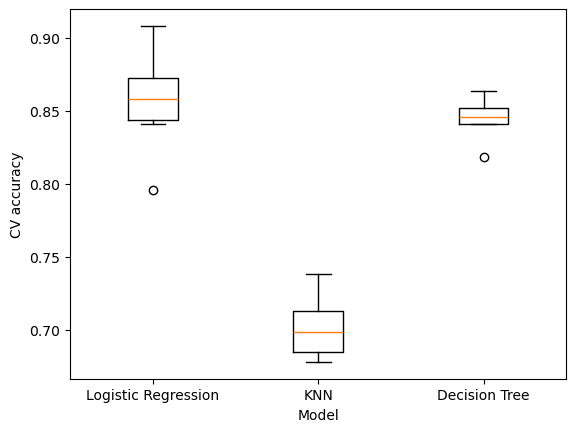

In [165]:

models = {"Logistic Regression":logReg, "KNN":knn, "Decision Tree":DecTree}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=1984, shuffle=True)
    cv_results = cross_val_score(model,X_train, y_train, cv=kf, scoring="accuracy")
    results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.ylabel("CV accuracy")
plt.xlabel("Model")
plt.show()

## **roc curve and roc-auc score**

### **The roc curves**

c:\Users\Angelique\anaconda3\envs\Essai\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


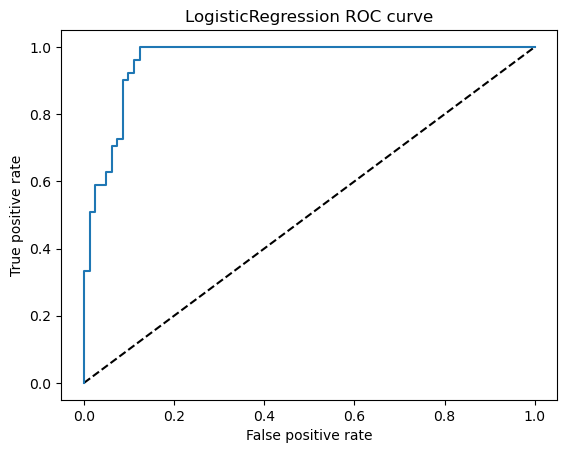

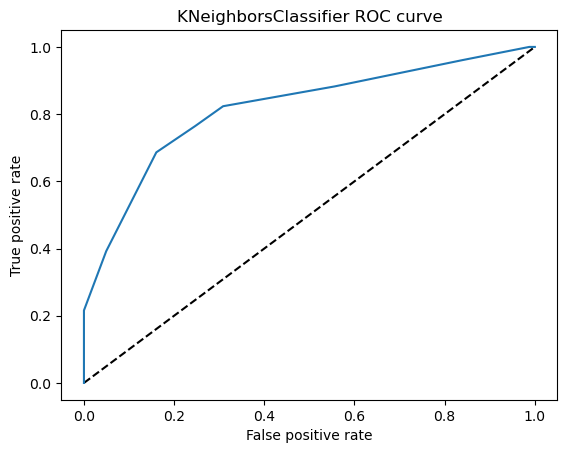

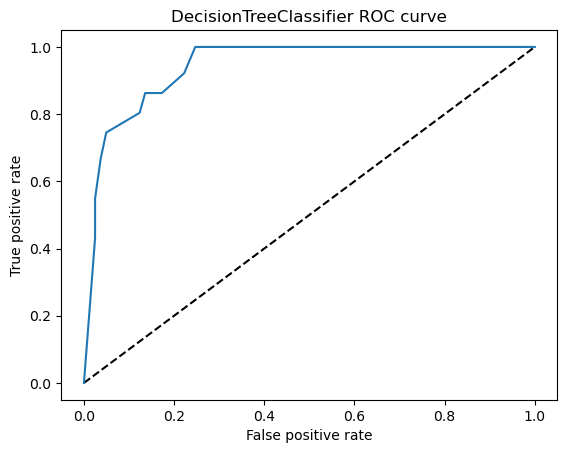

In [166]:
for model in models.values() :
    model.fit(X_train,y_train)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob)
    name= type(model).__name__
    plt.plot([0,1],[0,1],"k--")
    plt.plot(fpr,tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(f"{name} ROC curve")
    plt.show()



### **The roc-auc score**

In [167]:
for model in models.values() :
    model.fit(X_train,y_train)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test,y_pred_prob)
    name= type(model).__name__
    print(f"ROC-AUC score {name}: {score:.3f}")

ROC-AUC score LogisticRegression: 0.961
ROC-AUC score KNeighborsClassifier: 0.817
ROC-AUC score DecisionTreeClassifier: 0.942


c:\Users\Angelique\anaconda3\envs\Essai\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Using the ROC-AUC score metrics, we can see that Logictic Regression has a higher chance to find the correct predictions. Note that Decision Tree is not far behind with the chosen hyperparameter. I could tune it notably by using an ensemble model and perhaps could reach a better or at least similar result as with Logistic regression.  

# **Hyperparameter tuning for Logistic Regression**  
I found that Logistic Regression is a better fit with default hyperparameters. Can I reach an ever better performance if I tune some of these hyperparameters?  

In [168]:
logReg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

The main hyperparameters that we tune in Logistic regression are :  
- *solver* (the algorithm to use in the optimization problem). The default is 'lbfgs'.  
This solver performs well compared to other methods and it saves a lot of memory. However, it may have sometimes issues with convergence.  
- *penalty* intends to reduce model generalization error. It tries therefore to regulate overfitting by discouraging a more complex model. The default is 'l2'.  
However, some penalties don't work with every solver.  
- *C* or *regularization strength* must be apositive float. c works with penalty to regulate (or control) overfitting. Smaller values specify stronger regularization (minimize overfitting) while a high value tells the model to give high weight to the training data (more risk of overfitting). The default value is 1.

## **Grid search with these hyperparameters**  


In [169]:
params = {"solver":["liblinear"], "C":[10,1,0.8,0.4], "penalty":["l1","l2"]}
kf = KFold(n_splits=5, shuffle=True, random_state=1982)
grid_logReg = GridSearchCV(estimator=logReg, param_grid=params, scoring="roc_auc", cv=kf)
grid_logReg.fit(X_train,y_train)
best_model = grid_logReg.best_estimator_
print(f"The best hyperparameters are: {grid_logReg.best_params_}\n The best roc-auc score is: {grid_logReg.best_score_}")


The best hyperparameters are: {'C': 0.4, 'penalty': 'l2', 'solver': 'liblinear'}
 The best roc-auc score is: 0.9192753832692644


In [170]:
best_y_pred_prob = best_model.predict_proba(X_test)[:,1]
best_roc_auc = roc_auc_score(y_test,best_y_pred_prob)
print(best_roc_auc)

0.9682885499878964


I chose to replace the solver with 'liblinear' because it is recommended for high dimension set, which I have with 32 dimensions (features). However, this solver doesn't work with 'none' penalties while the default solver 'lbfgs' doesn't work with l1 penalty.  
Hence, I couldn't do a searchgrid with both solvers.
This best_model is slightly better than the one made with the default hyperparameters. 
